In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [4]:
scaler = MinMaxScaler()

def preprocessing(folder_name):
   # set file path
    folder_path = f'/content/drive/MyDrive/research/{folder_name}'

    # load file name in folder
    file_names = os.listdir(folder_path)
    data_array = []
    # data_list = []

    for file in file_names:
        # set file path
        file_path = os.path.join(folder_path, file)
        
        # load csv file as dataframe
        df = pd.read_csv(file_path)

        #preprocessing column
        df['open-close'] = df['Open'] - df['Adj Close'] #추가
        df['open-close'] = df['open-close'] + abs(min(df['open-close'])) #추가
        df['MA5'] = df['Close'].rolling(5).mean() #추가
        df = df.drop(['Date','Open','Close'], axis=1)
        df = df.rename(columns={'Adj Close':'Close'})
        df['Diff'] = df['High'] - df['Low']
        df = df.drop(['High','Low'], axis=1)

        #change 0 value to 0.000001
        #df = df.replace(0, 0.000001) -> np.log1p 메소드 사용

        #log transform
        df = np.log1p(df)

        #using minmaxscaler of each column in df
        df[['Close','Volume','Diff','open-close','MA5']] = scaler.fit_transform(df[['Close','Volume','Diff','open-close','MA5']])
        #df[['Close','Volume','Diff']] = scaler.fit_transform(df[['Close','Volume','Diff']])

        #insert list to array
        data_array.append(df)

    #list to numpy array and return
    return np.array(data_array)
        
        # save dataframe in variable without '.csv' extension
        # var_name = file.replace('.csv', '')
        # globals()[var_name] = df
        # data_list.append(var_name)

In [ ]:
#call preprocessing function
xGrowths = preprocessing('growth2000')
xValues = preprocessing('value2000')

<ipython-input-3-6bfbc1c11a45>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_array)
<ipython-input-3-6bfbc1c11a45>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_array)


In [ ]:
def bootstrap(data, n_samples):
    # generate bootstrap sample
    samples = []
    # sampling n_samples times
    for i in range(n_samples):
        # randomly sample from data with replacement
        sample = np.random.choice(data, size=1, replace=True)
        # append sample to ndarray
        samples = np.append(samples, sample)
    return samples

In [ ]:
n_samples = len(xValues) - len(xGrowths)
xGrowths_bootstrapped = bootstrap(xGrowths, n_samples)
xGrowths = np.concatenate((xGrowths, xGrowths_bootstrapped), axis=0)

In [ ]:
#generate y values
yGrowths = np.zeros(len(xGrowths))
yValues = np.ones(len(xValues))

In [ ]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

### skip

In [ ]:
#concatenate growths and values
x = np.concatenate((xGrowths, xValues), axis=0)
y = np.concatenate((yGrowths, yValues), axis=0)

In [ ]:
x_train, x_test, y_train, y_test = splitData(x, y)

In [ ]:
# # to give more weight to minority class
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [ ]:
x_train = pad_sequences(x_train, dtype='float32')
x_test = pad_sequences(x_test, dtype='float32')

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
#modify NaN to 0
x_train = np.nan_to_num(x_train, nan=0)
x_test = np.nan_to_num(x_test, nan=0)

In [ ]:
x_train.shape #2121 data samples, 1258 days, 3 features

(2121, 1258, 3)

## Baseline model

In [ ]:
from tensorflow.keras.layers import SimpleRNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(32, input_shape=(1258, 3)))
model.add(Dense(8))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1152      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#making 30% data
idx = np.random.choice(xGrowths.shape[0], int(xGrowths.shape[0]*0.3), replace=False)
xGrowths_30 = xGrowths[idx]
yGrowths_30 = yGrowths[idx]

idx = np.random.choice(xValues.shape[0], int(xValues.shape[0]*0.3), replace=False)
xValues_30 = xValues[idx]
yValues_30 = yValues[idx]

In [ ]:
#concatenate growths and values
x = np.concatenate((xGrowths, xValues), axis=0)
y = np.concatenate((yGrowths, yValues), axis=0)

In [ ]:
x_train, x_test, y_train, y_test = splitData(x, y)

x_train = pad_sequences(x_train, dtype='float32')
x_test = pad_sequences(x_test, dtype='float32')

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#modify NaN to 0
x_train = np.nan_to_num(x_train, nan=0)
x_test = np.nan_to_num(x_test, nan=0)

y_train = np.array([i[0] for i in y_train])
y_test = np.array([i[0] for i in y_test])

In [ ]:
x_train.shape

(635, 1258, 3)

In [ ]:
model.fit(x_train, y_train, epochs=1000)

Epoch 1/1000
20/20 [==============================] - 22s 763ms/step - loss: 1.0571 - acc: 0.5543
Epoch 2/1000
20/20 [==============================] - 15s 759ms/step - loss: 0.7007 - acc: 0.5512
Epoch 3/1000
20/20 [==============================] - 15s 745ms/step - loss: 0.6762 - acc: 0.5937
Epoch 4/1000
20/20 [==============================] - 15s 765ms/step - loss: 0.6625 - acc: 0.6110
Epoch 5/1000
20/20 [==============================] - 15s 777ms/step - loss: 0.6323 - acc: 0.6772
Epoch 6/1000
20/20 [==============================] - 16s 770ms/step - loss: 0.6421 - acc: 0.6646
Epoch 7/1000
20/20 [==============================] - 15s 745ms/step - loss: 0.6356 - acc: 0.6598
Epoch 8/1000
20/20 [==============================] - 15s 753ms/step - loss: 0.6139 - acc: 0.6772
Epoch 9/1000
20/20 [==============================] - 15s 753ms/step - loss: 0.6378 - acc: 0.6929
Epoch 10/1000
20/20 [==============================] - 15s 761ms/step - loss: 0.6444 - acc: 0.6520
Epoch 11/1000
20/20

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)

5/5 [==============================] - 1s 99ms/step


## original main code

In [ ]:
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(1258,3), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history=model.fit(x_train, y_train, epochs=3000, batch_size=64, validation_split=0.2, callbacks=[es, mc])

Epoch 1/3000
8/8 [==============================] - 8s 218ms/step - loss: 0.7005 - acc: 0.4685 - val_loss: 0.6906 - val_acc: 0.5669
Epoch 2/3000
8/8 [==============================] - 1s 100ms/step - loss: 0.6940 - acc: 0.5197 - val_loss: 0.6908 - val_acc: 0.5118
Epoch 3/3000
8/8 [==============================] - ETA: 0s - loss: 0.6897 - acc: 0.5512

KeyboardInterrupt: ignored

In [ ]:
model=load_model('best_model.h5')
loss, accuracy = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)

# 각 테스트 케이스의 예측 클래스 레이블 추출
y_pred = np.argmax(y_pred_prob, axis=-1)

# 예측 클래스 레이블 출력
print(y_pred)

17/17 [==============================] - 1s 35ms/step
[0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0
 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1
 1 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 1
 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0
 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1
 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 0
 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0
 0 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1
 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0

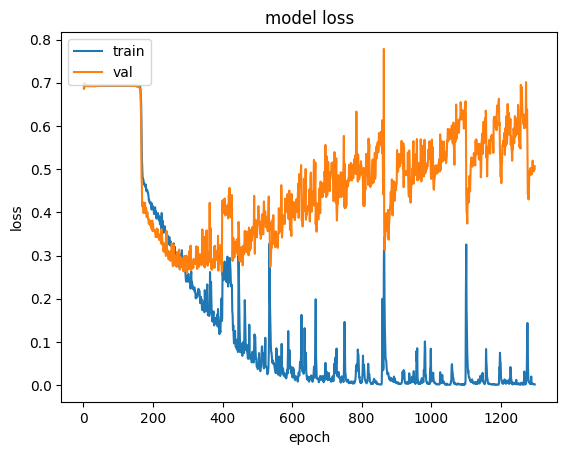

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

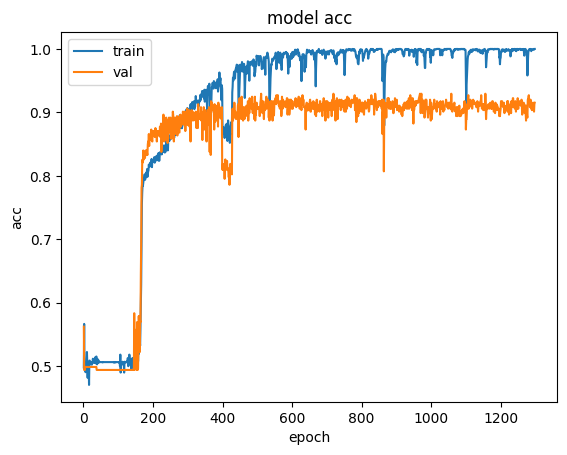

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## visualize the model architecture

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1258, 128)         67584     
                                                                 
 dropout_2 (Dropout)         (None, 1258, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 88,225
Trainable params: 88,225
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.trainable_variables

[<tf.Variable 'lstm_2/lstm_cell_2/kernel:0' shape=(3, 512) dtype=float32, numpy=
 array([[ 0.03628063,  0.01235028, -0.01409624, ..., -0.01039512,
          0.07761244,  0.1070199 ],
        [-0.07478158, -0.00261256, -0.00132481, ..., -0.02219396,
         -0.10127673,  0.01943927],
        [-0.00245505, -0.02204604, -0.0889032 , ..., -0.07509062,
          0.01708639,  0.04206457]], dtype=float32)>,
 <tf.Variable 'lstm_2/lstm_cell_2/recurrent_kernel:0' shape=(128, 512) dtype=float32, numpy=
 array([[-0.05906048, -0.04056412,  0.0423026 , ...,  0.02107093,
         -0.00527761,  0.00122657],
        [ 0.01561838, -0.03014757,  0.04170296, ...,  0.0555093 ,
         -0.04831932, -0.0459507 ],
        [ 0.04919062,  0.02992715, -0.08398689, ...,  0.03400297,
          0.03507067,  0.07790617],
        ...,
        [ 0.03431126,  0.03188544, -0.02482538, ...,  0.0482689 ,
         -0.05329587,  0.06107865],
        [ 0.01302868, -0.00867322,  0.0455145 , ...,  0.07254692,
          0.065

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 16.9 MB/s eta 0:00:00


In [ ]:
import inspect
print(inspect.getfile(visualkeras))

/usr/local/lib/python3.10/dist-packages/visualkeras/__init__.py


In [ ]:
import visualkeras

visualkeras.layered_view(model)

TypeError: ignored